In [2]:
#Importing all packages needed 
#1) Fundatmental 
import pandas as pd
import numpy as np

#2) Preprocessing 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

#3) Model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

#4) Validation  
from sklearn.model_selection import LeaveOneOut

#5) Performance metrics  
from sklearn.metrics import roc_auc_score, accuracy_score

#6) Graph
import matplotlib.pyplot as plt 

#7) Custom Functions
#!pip install ipynb
from ipynb.fs.full.Functions import *

import warnings
warnings.filterwarnings("ignore")


In [10]:
#Reading in the dataset
data=pd.read_spss("FTT.sav")  

#Taking the columns that are needed 
data_class=data[['groups','P_TAU','AB42','FTT_rate','FTT_variability_total_Log10','age', 'gender','education','AL','AT','RD','RDT','BNT','ANIMALES','VOSP_NUM','TMT_A','TMT_B','STROOP_LECT','STROOP_COLOR','STROOP_INT','SDMT',"PL_FTT_time_interval"]]

#Renaming the group name to biodiag to match the previous dataset1 and numbering also in the same way
data_class = data_class.rename(columns={'groups': 'biodiag'})
data_class['biodiag'] = data_class['biodiag'].replace({"grupo control":1, "grupo preclinico":2, "grupo con EA":3})

#Creating a dataframe for tapping features only
feat_select=data_class[["biodiag","FTT_variability_total_Log10","PL_FTT_time_interval","FTT_rate"]]

#1)Preclinical vs Control 
#Keeping only the subject in the control(1) and preclinical groups(2)
data_model=feat_select.loc[feat_select['biodiag'].isin([1,2])]
#Making lables binary
factor = pd.factorize(data_model['biodiag'])
data_model.biodiag = factor[0]

#Normalizing data
scaler = MinMaxScaler()
data_model = pd.DataFrame(scaler.fit_transform(data_model), columns = data_model.columns)
imputer = KNNImputer(n_neighbors=5)
#Imputing missing values with knn
data_model = pd.DataFrame(imputer.fit_transform(data_model),columns = data_model.columns)
y = data_model.loc[:, data_model.columns == "biodiag"]
X=data_model.loc[:, data_model.columns != "biodiag"]

# 1. Grid Search

First we do a gridsearch to investigate if we can improve our model performance. We do this on 4 parameters taht are commonly associated with overfitting, namely, *n_estimators*, *max_depth*, *criterion*, *min_samples_leaf*. 

In [4]:
#Setting up the parameter space for the grid search
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 30)]
max_depth = [4,5,6,7,8]+[int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
criterion =['gini', 'entropy']
min_samples_leaf = [1, 2, 4]

#combining the parameters
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

In [40]:
#Setting the model 
clf=RandomForestClassifier()

#Defining leave one out cross validation
def LeaveOneOut_predict_proba(clf, X, y, i):
    clf.fit(X.drop(i), y.drop(i))
    return clf.predict_proba(X.loc[[i]])[0, 1]

#Performing the grid search
#defining resulting values to initiate 
best_params=list()
final_roc_auc_score=0
#Getting all sets of parameters in the parameter space as defined above 
#For each parameter set computing the AUC and finally returning the optimal value
for params in ParameterGrid(random_grid):
    clf.set_params(**params)
    y_proba = [LeaveOneOut_predict_proba(clf, X, y, i) for i in X.index]
    new_roc_auc_score=roc_auc_score(y, y_proba)
    if new_roc_auc_score>final_roc_auc_score:
        final_roc_auc_score=new_roc_auc_score
        best_params=params
print(best_params)
print("%.3f" % (final_roc_auc_score))

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 10}
0.815


This indicates that the best parameters based on grid search are, criterion="entropy", max_depth=50, min_samples_leaf=2 and n_estimators=10. Next we test the performance of these parameters on the model.

# 1.1 Adding the optimal parameters to the model

In [11]:
#Preparing the data
#dropping the biomarkers that should not be used in this model
#feat_select=data_class.drop(["P_TAU","AB42","STROOP_LECT","gender","ANIMALES","RDT","VOSP_NUM","education","AL","RD","BNT","AT","TMT_A"],axis=1)
feat_select=data_class[["biodiag","FTT_variability_total_Log10","PL_FTT_time_interval","FTT_rate"]]

#1)Preclinical vs Control 
#Keeping only the subject in the control(1) and preclinical groups(2)
data_model=feat_select.loc[feat_select['biodiag'].isin([1,2])]
#Calling the function data_prep to further prepare the dataset:
#One hot encodes the group variable (biodiag)
#Splits the data into X and y, and turns then into the desired format, an array
X,y,coulmnNames=data_prep(data_model)
#Oversampling the dataset with SMOTE
X,y= smote_data(SMOTE,None,X, y)

#Call the function featureimportance to run the model
acc, roc_auc, featureImportance,sensitivity,specificity=featureimportance(X,y,RandomForestClassifier(random_state=1,criterion='entropy', max_depth= 50, min_samples_leaf= 1, n_estimators= 10),MinMaxScaler,KNNImputer)
print("For control vs AD preclinical the accuracy is %.3f and the auc is %.3f" % (acc, roc_auc))
print("For control vs AD preclinical the sensitivity is %.3f and the specificity is %.3f" % (sensitivity, specificity))
print_importance(featureImportance,coulmnNames)

For control vs AD preclinical the accuracy is 0.784 and the auc is 0.784
For control vs AD preclinical the sensitivity is 0.703 and the specificity is 0.865
                       feature  importance
1         PL_FTT_time_interval    0.384413
0  FTT_variability_total_Log10    0.327429
2                     FTT_rate    0.288158


The grid search performs worse than that of the default parameters which returned an AUC of 0.797. Also considering that the dataset is small, we could not set aside a fresh test set aside, i.e run the grid search with LOOCV on the training set, then evaluate the final model on the fresh test set. Therefore the approach we took could lead to data leakage, thus we will not consider the parameters from the gridsearch. 


# 2. Overfitting

A complex model can lead to over-fitting the random effects that are present only in the specific data-set used for training. If these random effects are not present in the test/unseen data, the model will produce incorrect predictions for the test data. To check if this is an issue we can measure the model's performance on the test dataset that was not used during training and on the training dataset itself. 

We do this for some of the model's parameters that can influence overfitting. We take a range for each of the parameters and plot the training and test AUC for each of the parameters values in the defined range. If overfitting is present we expect to see a divergence between the training and test AUC. 



In [19]:
#Define a function that will return the train and test AUC through leave one out cross validation.
def LOOCV_overfitting(X,y,model,scaler,imputer):
    #define the split mechanism as leave one out for evaluation 
    cv = LeaveOneOut()
    model=model
    #Create three lists to store the true y values (real and predicted) and the importance values for each iteration of leave one out validation
    y_true, y_pred = list(), list()
    #Run the leave one out 
    for train_ix, test_ix in cv.split(X):
        # split data, using just one sample as the test 
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        #Scale the data if called in the definition, where "None" means no scaling is applied
        X_train,X_test=scale_data(scaler,X_train,X_test)
        #Impute missing values using the technique indicated where "knn" is k-nearest neighbor and "mean" is the mean.
        X_train,X_test=impute_data(imputer,X_train,X_test)
        #Fit the model
        model.fit(X_train, y_train)
        #Evaluate the model
        yhat = model.predict(X_test)
        #Store the predicted and true values of "y"
        y_true.append(y_test[0])
        y_pred.append(yhat[0])
    
    #Calculate training AUC
    y_pred_train=model.predict(X_train)
    fpr_train,tpr_train,threshold=roc_curve(y_train,y_pred_train,pos_label=1)
    roc_auc_train = auc(fpr_train, tpr_train)
    
        
    #Calculate test AUC
    fpr,tpr,threshold=roc_curve(y_true,y_pred,pos_label=1)
    roc_auc_test = auc(fpr, tpr)
    
    return roc_auc_train,roc_auc_test

# 2.1 Number of Trees (n_estimators)

No sign of overfitting since the test AUC doesn't drop nor does the train AUC increase.

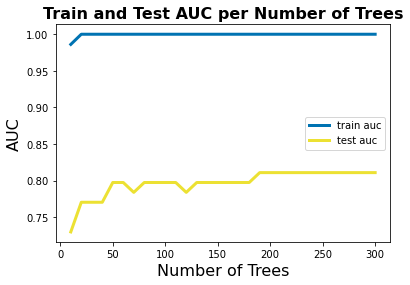

In [20]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 30)]

auc_train, auc_test, n_estimator_list=list(),list(),list()
for i in n_estimators:
    roc_auc_train,roc_auc_test=LOOCV_overfitting(X,y,RandomForestClassifier(random_state=1,n_estimators=i),scaler,imputer)
    auc_train.append(roc_auc_train)
    auc_test.append(roc_auc_test)
    n_estimator_list.append(i)
    
    
plt.plot(n_estimator_list, auc_train,   label = 'train auc', linewidth=3,color="#0073b2")
plt.plot(n_estimator_list, auc_test,   label = 'test auc', linewidth=3,color="#ece133")

plt.xlabel('Number of Trees',size=16)
plt.ylabel('AUC',size=16)
plt.legend(loc=7)
plt.title('Train and Test AUC per Number of Trees',size=16,fontweight="bold")
plt.show()


# 2.2 Maximum depth (max_depth)

No sign of overfitting since the test AUC doesn't drop nor does the train AUC increase.

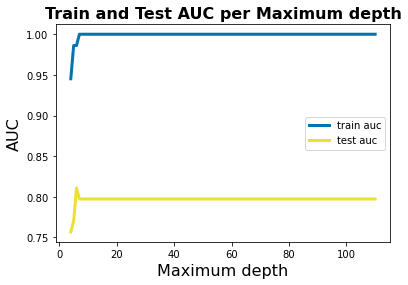

In [21]:
max_depth = [4,5,6,7,8]+[int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

auc_train, auc_test, max_depth_list=list(),list(),list()
for i in max_depth:
    roc_auc_train,roc_auc_test=LOOCV_overfitting(X,y,RandomForestClassifier(random_state=1,max_depth=i),scaler,imputer)
    auc_train.append(roc_auc_train)
    auc_test.append(roc_auc_test)
    max_depth_list.append(i)
    
    
plt.plot(max_depth_list, auc_train,   label = 'train auc', linewidth=3,color="#0073b2")
plt.plot(max_depth_list, auc_test,   label = 'test auc', linewidth=3,color="#ece133")

plt.xlabel('Maximum depth',size=16)
plt.ylabel('AUC',size=16)
plt.legend(loc=7)
plt.title('Train and Test AUC per Maximum depth',size=16,fontweight="bold")
plt.show()


# 2.3 Minimum samples per leaf (min_samples_leaf)

Sign of overfitting with the minimum of sample leaf equals to 1 (This is the default value). This is because with a value of 1, it means the tree in the end could potentially have one leaf for each sample which will 100% will overfit.  We can choose a value of 2 to avoid this from happening. 

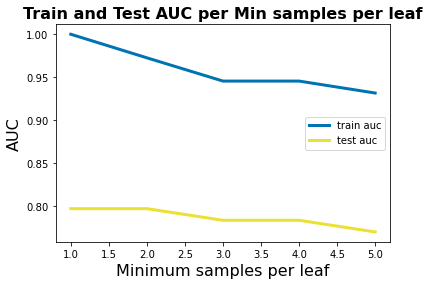

In [23]:
min_samples_leaf=[1,2,3,4,5]

auc_train, auc_test, min_samples_leaf_list=list(),list(),list()
for i in min_samples_leaf:
    roc_auc_train,roc_auc_test=LOOCV_overfitting(X,y,RandomForestClassifier(random_state=1,min_samples_leaf=i),scaler,imputer)
    auc_train.append(roc_auc_train)
    auc_test.append(roc_auc_test)
    min_samples_leaf_list.append(i)
    
    
plt.plot(min_samples_leaf_list, auc_train,   label = 'train auc', linewidth=3,color="#0073b2")
plt.plot(min_samples_leaf_list, auc_test,   label = 'test auc', linewidth=3,color="#ece133")

plt.xlabel('Minimum samples per leaf',size=16)
plt.ylabel('AUC',size=16)
plt.legend(loc=7)
plt.title('Train and Test AUC per Min samples per leaf',size=16,fontweight="bold")
plt.show()


# 2.4 Rerun the model with the new parameter (min_samples_leaf=2)

In [24]:
#Preparing the data
#dropping the biomarkers that should not be used in this model
#feat_select=data_class.drop(["P_TAU","AB42","STROOP_LECT","gender","ANIMALES","RDT","VOSP_NUM","education","AL","RD","BNT","AT","TMT_A"],axis=1)
feat_select=data_class[["biodiag","FTT_variability_total_Log10","PL_FTT_time_interval","FTT_rate"]]

#1)Preclinical vs Control 
#Keeping only the subject in the control(1) and preclinical groups(2)
data_model=feat_select.loc[feat_select['biodiag'].isin([1,2])]
#Calling the function data_prep to further prepare the dataset:
#One hot encodes the group variable (biodiag)
#Splits the data into X and y, and turns then into the desired format, an array
X,y,coulmnNames=data_prep(data_model)
#Oversampling the dataset with SMOTE
X,y= smote_data(SMOTE,None,X, y)

#Call the function featureimportance to run the model
acc, roc_auc, featureImportance,sensitivity,specificity=featureimportance(X,y,RandomForestClassifier(random_state=1,min_samples_leaf=2),MinMaxScaler,KNNImputer)
print("For control vs AD preclinical the accuracy is %.3f and the auc is %.3f" % (acc, roc_auc))
print("For control vs AD preclinical the sensitivity is %.3f and the specificity is %.3f" % (sensitivity, specificity))
print_importance(featureImportance,coulmnNames)


For control vs AD preclinical the accuracy is 0.797 and the auc is 0.797
For control vs AD preclinical the sensitivity is 0.811 and the specificity is 0.784
                       feature  importance
1         PL_FTT_time_interval    0.342423
2                     FTT_rate    0.330159
0  FTT_variability_total_Log10    0.327418
